This project more focusing on using MLFlow library which can help us to organized our machine learning project.

Credit to this notebook's author : https://www.kaggle.com/embed/dragonduck/property-listing-analysis?kernelSessionId=16710647

# Imports

In [2]:
import numpy as np
np.random.seed(101)
import requests
import time
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
import sklearn.metrics
import keras.models
import keras.layers

# Data Preprocessing
The raw data that I collected needs to be preprocessed and the columns cleaned.

In [3]:
properties = pd.read_csv("raw-data/data_kaggle.csv")

In [4]:
properties.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


## Price
As a first step, I'll remove all entries with missing prices as the price will be one of the target features to predict down the road.

In [5]:
properties = properties.loc[~properties["Price"].isna()]

Next, I want to make sure that every remaining entries matches the same format of "RM" followed by commas and digits.

In [6]:
incorrect_entries = np.sum(~properties["Price"].str.match(r"RM [0-9,]*$"))
print("There are {} entries in the wrong format.".format(incorrect_entries))

There are 0 entries in the wrong format.


In [7]:
# Strip the price of the "RM" as well as commas
def strip_price(text):
    text = text.replace("RM", "")
    text = text.replace(",", "")
    text = text.strip()
    return int(text)
    
properties["Price"] = properties["Price"].apply(strip_price)

## Location

A common issue is capitalization, so let's make everything lower case. Additionally, let's remove the city name as I explicitly only scraped entries from Kuala Lumpur.

In [8]:
properties["Location"] = properties["Location"].str.lower()
properties["Location"] = properties["Location"].str.replace(r", kuala lumpur$", "", regex=True)

A look at the unique location values shows that they are reasonably standardized. 

In [9]:
sorted(properties["Location"].unique())

['adiva desa parkcity',
 'alam damai',
 'ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bandar sri damansara',
 'bandar tasik selatan',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit  persekutuan',
 'bukit bintang',
 'bukit damansara',
 'bukit jalil',
 'bukit kiara',
 'bukit ledang',
 'bukit tunku (kenny hills)',
 'canary residence',
 'casa rimba',
 'chan sow lin',
 'cheras',
 'city centre',
 'country heights damansara',
 'cyberjaya',
 'damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'duta nusantara',
 'dutamas',
 'federal hill',
 'gombak',
 'gurney',
 'happy garden',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'jalan u-thant',
 'jinjang',
 'kemensah',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kota damansara',
 'kuala lumpur',
 'kuchai lama',
 'landed sd',
 'mid valley city',
 'mont kiara',
 'off gasing indah,',
 

A bigger issue are regions with very few properties posted. The frequency distribution, plotted logarithmically, looks as follows. A significant number of regions have very few properties listed, making them difficult to work with. I would need to have relative geographical locations of each neighborhood to properly clean the location data. As an initial step, I simply remove entries in locations with fewer than $100$ properties listed.

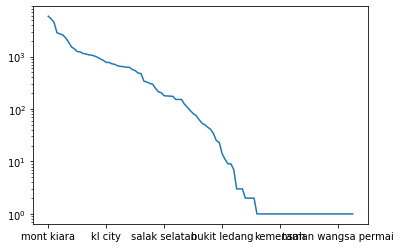

In [10]:
properties["Location"].value_counts().plot(logy=True);

In [11]:
significant_locations = properties["Location"].value_counts()[
    properties["Location"].value_counts() >= 100].index

properties = properties.loc[np.isin(properties["Location"], significant_locations)]

A new look at the locations shows that there are no more ambiguous names.

In [12]:
sorted(properties["Location"].unique())

['ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit bintang',
 'bukit jalil',
 'bukit tunku (kenny hills)',
 'cheras',
 'city centre',
 'country heights damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'dutamas',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kuchai lama',
 'mont kiara',
 'oug',
 'pandan perdana',
 'pantai',
 'salak selatan',
 'segambut',
 'sentul',
 'seputeh',
 'setapak',
 'setiawangsa',
 'sri hartamas',
 'sri petaling',
 'sungai besi',
 'sunway spk',
 'taman desa',
 'taman melawati',
 'taman tun dr ismail',
 'titiwangsa',
 'wangsa maju']

## Number of Rooms
The number of rooms contains some irregularities. For example, it is common for rooms to be listed as N+M instead of the total number of rooms. I want to clean the `Rooms` column and introduce a numerical equivalent.

In [13]:
sorted(properties["Rooms"].unique().astype(str))

['1',
 '1+1',
 '1+2',
 '10',
 '10+',
 '10+1',
 '11',
 '11+1',
 '12',
 '12+',
 '13',
 '13+',
 '13+1',
 '14',
 '15+',
 '16',
 '18',
 '2',
 '2+1',
 '2+2',
 '20 Above',
 '3',
 '3+1',
 '3+2',
 '4',
 '4+1',
 '4+2',
 '5',
 '5+1',
 '5+2',
 '6',
 '6+',
 '6+1',
 '7',
 '7+',
 '7+1',
 '8',
 '8+',
 '8+1',
 '9',
 '9+',
 '9+1',
 'Studio',
 'nan']

In [14]:
def convert_room_num(rooms):
    try:
        if rooms.endswith("+"):
            return int(rooms[:-1])
        if re.search("[0-9]+\+[0-9]+", rooms) is not None:
            tmp = rooms.split("+")
            return int(tmp[0]) + int(tmp[1])
        if rooms == "20 Above":
            return 20
        if rooms == "Studio":
            return 1
        return int(rooms)
    except AttributeError:
        return rooms

properties["Rooms Num"] = properties["Rooms"].apply(convert_room_num)

In [15]:
properties["Rooms Num"].value_counts(dropna=False)

3.0     15938
4.0     13027
5.0      6827
2.0      6547
6.0      3747
1.0      3191
7.0      1564
NaN      1560
8.0       361
9.0       102
10.0       45
12.0       14
11.0        8
20.0        7
13.0        4
14.0        3
16.0        2
15.0        1
18.0        1
Name: Rooms Num, dtype: int64

# Property Type
There are several different property types that are typical for Malaysia. A brief glance at the full list  of property types seems overwhelming at first.

In [16]:
properties["Property Type"].value_counts()

Condominium                               11447
Serviced Residence                         7176
Condominium (Corner)                       5687
Condominium (Intermediate)                 5113
Serviced Residence (Intermediate)          3255
                                          ...  
4-sty Terrace/Link House (Penthouse)          1
3-sty Terrace/Link House (Triplex)            1
2-sty Terrace/Link House (Penthouse)          1
2.5-sty Terrace/Link House (Penthouse)        1
4.5-sty Terrace/Link House (Corner)           1
Name: Property Type, Length: 95, dtype: int64

I can greatly simplify the property types, however, by trimming information. For example, there are many different variations of the Terrace/Link houses that can be grouped together. I create a new category of only the property type "super groups".

In [17]:
def simplify_property_type(prop_type):
    super_types = [
        "Terrace/Link House", "Serviced Residence", "Condominium", 
        "Semi-detached House", "Bungalow", "Apartment", "Townhouse", 
        "Flat", "Residential Land", "Cluster House"]
    for super_type in super_types:
        if re.search(super_type, prop_type, flags=re.IGNORECASE) is not None:
            return super_type
    
    return prop_type

properties["Property Type Supergroup"] = properties["Property Type"].apply(simplify_property_type)

In [18]:
properties["Property Type Supergroup"].value_counts(dropna=False)

Condominium            23149
Serviced Residence     13399
Terrace/Link House      7567
Bungalow                3598
Semi-detached House     2102
Apartment               1621
Residential Land         669
Townhouse                508
Flat                     330
Cluster House              6
Name: Property Type Supergroup, dtype: int64

## Furnishing
The furnishing column thankfully doesn't require any cleaning.

In [19]:
properties["Furnishing"].value_counts(dropna=False)

Partly Furnished    26222
Fully Furnished     13846
NaN                  6687
Unfurnished          5611
Unknown               583
Name: Furnishing, dtype: int64

## Size
The size apparently always has the same structure:

    [Built-up/Land area] : [Value] sq. ft.

In [20]:
properties[["Size"]].sample(25)

,Size
44370,"Built-up : 9,000 sq. ft."
24474,"Built-up : 2,002 sq. ft."
38244,Land area : 3046 sq. ft.
11381,Built-up : 522 sq. ft.
36948,Land area : 1659 sq. ft.
45748,Built-up : 950 sq. ft.
48529,Land area : 6000 sq. ft.
36563,Built-up : 729 sq. ft.
36203,"Built-up : 3,983 sq. ft."
16770,Built-up : 900 sq. ft.


So I will create two new column that indicate whether this is built-up or land area and store the actual square footage.

In [21]:
def split_size(val, index=0):
    try:
        return val.split(":")[index].strip()
    except AttributeError:
        return val
    
properties["Size Type"] = properties["Size"].apply(split_size, index=0)
properties["Size Num"] = properties["Size"].apply(split_size, index=1)

In [22]:
properties["Size Type"].value_counts(dropna=False)

Built-up     37493
Land area    14453
NaN           1003
Name: Size Type, dtype: int64

Now I need to strip the new `Size_num` column and convert it to a numerical value.

In [23]:
properties['Size Num'].value_counts()

22x75 sq. ft.    597
1,100 sq. ft.    540
950 sq. ft.      520
850 sq. ft.      384
1,200 sq. ft.    380
                ... 
33x60 sq. ft.      1
4,573 sq. ft.      1
3573 sq. ft.       1
4692 sq. ft.       1
1544 sq. ft.       1
Name: Size Num, Length: 5849, dtype: int64

In [24]:
def convert_size_num(size):
    # Attempt to trim the numbers down. Most of this is done explicitly without
    # regex to avoid incorrect trimming, which would lead to the concatenation
    # of numbers. I would rather have missing values than incorrectly cleaned
    # numbers.
    try:
        # If it's not in square feet then I don't want to deal with all
        # possible conversions for now.
        if re.search(r"sq\.*\s*ft\.*", size) is None:
            return None
    
        size = size.replace(",", "") # eg 2550, 34x75 sq. ft.
        size = size.replace("'", "") # eg 22'x 75' sq. ft.
        size = size.replace("sq. ft.", "") # eg 2550, 34x75 sq. ft.
        size = size.replace("sf", "") # eg 646sf~1001sf sq. ft.
        size = size.strip()
        size = size.lower()
        
        add_mult_match = re.search(r"(\d+)\s*\+\s*(\d+)\s*(?:x|\*)\s*(\d+)", size) # eg 10+24 x 80 sq. ft.
        if add_mult_match is not None:
            return int(add_mult_match.groups()[0]) + (
                int(add_mult_match.groups()[1]) * 
                int(add_mult_match.groups()[2]))
        
        mult_match = re.search(r"(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if mult_match is not None:
            return int(mult_match.groups()[0]) * int(mult_match.groups()[1])
        
        return int(size)
    # If any of the above doesn't work, just turn it into None/NaN
    # We want to guarantee this column is numeric
    except:
        return None
        
properties["Size Num"] = properties["Size Num"].apply(convert_size_num)

Cleaning the property sizes introduced only a small number of additional missing values.

In [25]:
print("Properties with missing raw size data: {}".format(properties["Size"].isna().sum()))
print("Properties with missing size type data: {}".format(properties["Size Type"].isna().sum()))
print("Properties with missing size num data: {}".format(properties["Size Num"].isna().sum()))

Properties with missing raw size data: 1003
Properties with missing size type data: 1003
Properties with missing size num data: 1313


I will synchronize the missing values between the `Size Type` and `Size Num` columns.

In [26]:
properties.loc[properties["Size Num"].isna(), "Size Type"] = None

In [27]:
properties.loc[:, "Size Type"].value_counts(dropna=False)

Built-up     37455
Land area    14181
NaN           1313
Name: Size Type, dtype: int64

## Other columns
The number of bathrooms and car parks are standardized and do not require any further cleaning.

In [28]:
properties["Bathrooms"].value_counts(dropna=False)

2.0     21163
3.0      9331
4.0      6522
5.0      4717
1.0      4482
6.0      3172
NaN      1866
7.0      1031
8.0       402
9.0       142
10.0       70
12.0       14
11.0       11
20.0       10
15.0        6
13.0        5
14.0        4
16.0        1
Name: Bathrooms, dtype: int64

In [29]:
properties["Car Parks"].value_counts(dropna=False)

NaN     17042
2.0     15174
1.0     13622
3.0      3798
4.0      1913
6.0       623
5.0       501
8.0        91
10.0       76
7.0        62
12.0        7
15.0        7
13.0        7
9.0         4
28.0        4
11.0        4
20.0        4
30.0        4
16.0        2
17.0        2
18.0        1
24.0        1
Name: Car Parks, dtype: int64

## Price per Area / Room
As a last step, I want to introduce the price per area and price per rooms as features

In [30]:
properties["Price per Area"] = properties["Price"] / properties["Size Num"]
properties["Price per Room"] = properties["Price"] / properties["Rooms Num"]

## Save Preprocessed Data

In [31]:
properties.to_csv("data/Properties_preprocessed.csv")

# Predictive Modelling

## Preparing the Data
As a short exercise in predictive modelling, I want to try to predict the price of a property based on the characteristics listed here. Due to the heterogeneity of the data, I will only look at a subset of the property listings to reduce the number of potentially confounding factors. In particular, I will:

- Look only at entries with "built-up" area listed. This is because built-up size and land area are, strictly speaking, two different features.
- Look only at entries without missing values for features (see below for a detailed description of which features I use).

I will also be selective about the features I include in the model. As categorical features would have to be converted to dummy features, e.g. the `Rooms` feature would be converted to boolean "has_3_rooms", "has_3+1_rooms", etc., I will try to use numerical versions of the features where possible. Specifically, the following features will _not_ be used:

- `Rooms`, which will be replaced with `Rooms Num`
- `Size`, which will be replaced with `Size Num`
- `Size Type`, as this will always be "built-up" in the reduced data frame)
- `Property Type`, as there are simply too many variants. I instead use `Property Type Supergroup`.

This means our model will consider the following features:

- `Location` (converted to binary dummy features)
- `Bathrooms`
- `Car Parks`
- `Furnishing`
- `Rooms Num`
- `Property Type Supergroup`
- `Size Num`

And the model will be trained to predict any of the three price columns, `Price`, `Price per Area`, and `Price per Room`.

Lastly, I will make the assumption that a missing entries for `Car Parks` is 0. While not necessarily true, it is likely to be the case for many entries. However, I will not make the same assumption for `Bathrooms`, as a (built up) property will have at least one bathroom.

In [32]:
# Remove entries with "land area" in the "Size Type" column
Xy = properties.loc[properties["Size Type"] == "Built-up"]

# Keep only the relevant features
Xy = Xy.loc[:, [
    "Location", "Bathrooms", "Car Parks", "Furnishing", 
    "Rooms Num", "Property Type Supergroup", "Size Num", 
    "Price", "Price per Area", "Price per Room"]]

# Fill missing Car Parks feature values
Xy.loc[:, "Car Parks"] = Xy["Car Parks"].fillna(0)

# Remove entries with missing values
Xy = Xy.loc[Xy.isna().sum(axis=1) == 0]

# Specifically remove entries with "Unknown" furnishing status
Xy = Xy.loc[Xy["Furnishing"] != "Unknown"]

# Convert to dummy features
Xy = pd.get_dummies(Xy)

In [33]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (32413, 68)


The data frame now consists of only numerical features:

In [34]:
print("Data frame DTYPES:")
for dtype in Xy.dtypes.unique():
    print(" - {}".format(dtype))

Data frame DTYPES:
 - float64
 - int64
 - uint8


## Feature Selection
Beyond the intial preprocessing, I obviously want to perform feature selection as well. Some features may be heavily correlated.

### Outlier removal
The first step is to remove outliers from the original numerical features. Until now, I've used a robust aggregator (the median) and outliers have been irrelevant, but they can become a thorn in our side for predictive modelling.

I remove `Size Num` outliers heuristically. The smallest reasonable value, as can be seen from the data, corresponds to $250$ square feet. This corresponds to a small studio apartment. Ergo I use this as the lower threshold for potential values.

In [35]:
Xy["Size Num"].sort_values().head(10)

7724      11.0
26309    250.0
44334    250.0
43156    250.0
23544    250.0
49397    250.0
53436    250.0
33466    250.0
42080    250.0
52309    250.0
Name: Size Num, dtype: float64

On the opposite end of the spectrum, there appear to be several unreasonably large properties ($820000$ square feet corresponds to the approximate size of the Louvre museum in Paris, France). I heuristically set the cutoff at $20000$ square feet for the maximum size of a property.

In [36]:
Xy["Size Num"].sort_values(ascending=False).head(20)

26310    820000.0
2437     790000.0
23507    690000.0
9339     576000.0
50850    320015.0
43550    166821.0
50824     60000.0
28733     50000.0
21072     23716.0
45085     19180.0
28888     18222.0
19070     17000.0
43686     17000.0
12089     16500.0
27843     15000.0
52747     14875.0
4688      14570.0
38448     14410.0
51742     13939.0
52636     13000.0
Name: Size Num, dtype: float64

In [37]:
Xy = Xy.loc[Xy["Size Num"].between(250, 20000)]

From the remaining three originally numerical columns, `Bathrooms`, `Car Parks`, and `Rooms Num`, I trim the top and bottom $0.1\%$ of all entries.

In [38]:
selectors = []
for feature in ["Bathrooms", "Car Parks", "Rooms Num"]:
    selectors.append(Xy[feature].between(
        Xy[feature].quantile(0.001), 
        Xy[feature].quantile(0.999)))

Xy = Xy.loc[(~pd.DataFrame(selectors).T).sum(axis=1) == 0]

All further feature selection will be performed on a subset of the data that will _not_ be used for training the model itself to avoid overfitting.

In [39]:
Xy, Xy_feature_selection = sklearn.model_selection.train_test_split(
    Xy, test_size=0.25, random_state=101)

In [40]:
Xy.shape

(24260, 68)

In [41]:
Xy_feature_selection.shape

(8087, 68)

### Feature Scaling
First, the original numerical features must be scaled (the binary dummy features don't need to be scaled).

c:\users\commander\anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


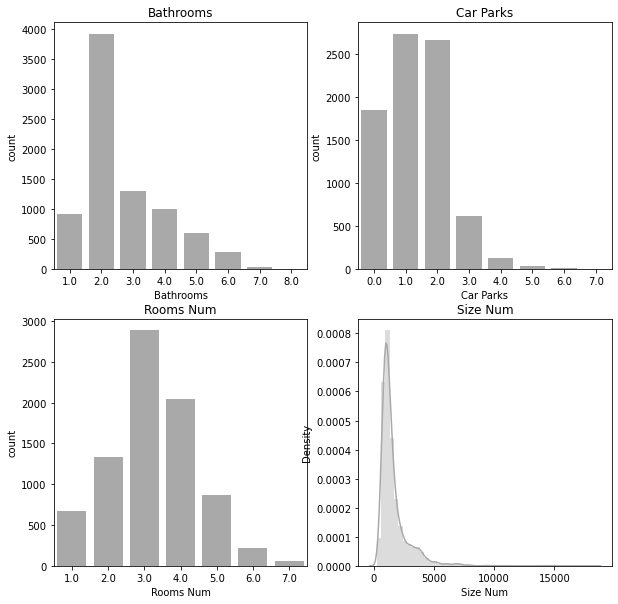

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10));
sns.countplot(data=Xy_feature_selection, x="Bathrooms", ax=ax[0, 0], color="darkgrey");
ax[0, 0].set_title("Bathrooms");
sns.countplot(data=Xy_feature_selection, x="Car Parks", ax=ax[0, 1], color="darkgrey");
ax[0, 1].set_title("Car Parks");
sns.countplot(data=Xy_feature_selection, x="Rooms Num", ax=ax[1, 0], color="darkgrey");
ax[1, 0].set_title("Rooms Num");
sns.distplot(a=Xy_feature_selection["Size Num"], bins=50, ax=ax[1, 1], color="darkgrey");
ax[1, 1].set_title("Size Num");

As none of the features seem to be normally distributed, I will simply scale them to lie between 0 and 1. Note that the data sets for training and feature selection are scaled separately!

In [43]:
cols = ["Bathrooms", "Car Parks", "Rooms Num", "Size Num"]
Xy_feature_selection[cols] = sklearn.preprocessing.MinMaxScaler().fit_transform(
    Xy_feature_selection[cols])
Xy[cols] = sklearn.preprocessing.MinMaxScaler().fit_transform(Xy[cols])

### Feature Correlation
I look at the correlation between the initial numerical features to determine if they can be pruned.

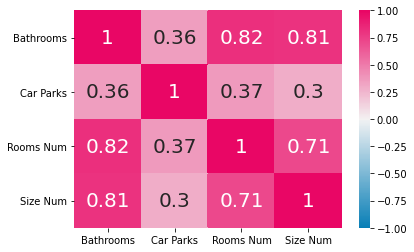

In [44]:
hm_cmap = sns.diverging_palette(240, 0, s=99, l=50, as_cmap=True)
df = Xy_feature_selection[["Bathrooms", "Car Parks", "Rooms Num", "Size Num"]].corr()
sns.heatmap(data=df, vmin=-1, vmax=1, cmap=hm_cmap, annot=df, annot_kws={"size": 20});

Based on the above correlation matrix, the features `Bathrooms` and `Rooms Num` both correlate very strongly with `Size Num` and can be safely removed.

Remove the actual features from the dataset(s)

In [45]:
Xy = Xy.drop(["Bathrooms", "Rooms Num"], axis=1)
Xy_feature_selection = Xy_feature_selection.drop(["Bathrooms", "Rooms Num"], axis=1)

In addition to the features, I also want to look at the potential target variables and how they correlate.

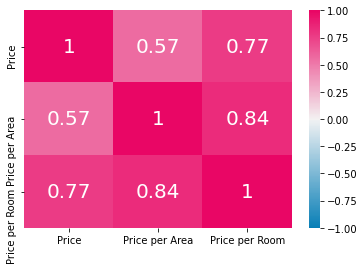

In [46]:
df = Xy_feature_selection[["Price", "Price per Area", "Price per Room"]].corr()
sns.heatmap(
    df, vmin=-1, vmax=1, cmap=hm_cmap, 
    annot=np.round(df, 2), annot_kws={"size": 20})

`Price per Area` and `Price per Room` correlate very strongly so that it makes little sense to retain both. I consequently remove `Price per Room`.

In [47]:
Xy = Xy.drop("Price per Room", axis=1)
Xy_feature_selection = Xy_feature_selection.drop("Price per Room", axis=1)

## Modelling

In [60]:
from mlflow import log_metric, log_param, log_artifacts
import mlflow.sklearn
import mlflow

Split data into training and test set

In [49]:
Xy_train, Xy_test = sklearn.model_selection.train_test_split(Xy, test_size=0.2, random_state=101)
X_train = Xy_train.drop(["Price", "Price per Area"], axis=1)
y_train = Xy_train[["Price", "Price per Area"]]
X_test = Xy_test.drop(["Price", "Price per Area"], axis=1)
y_test = Xy_test[["Price", "Price per Area"]]

Define convenience function to train and test a `scikit-learn` model.

In [70]:
def train_and_test_model(
        model, X_train=X_train, y_train=y_train, 
        X_test=X_test, y_test=y_test, **kwargs):
    
    mlflow.sklearn.autolog(log_models=True)
    with mlflow.start_run():
        model.fit(X_train, y_train, **kwargs)
        y_pred = model.predict(X_test)
        r2 = sklearn.metrics.r2_score(y_true=y_test, y_pred=y_pred)

        log_param("param1", 1)

        # Log a metric; metrics can be updated throughout the run
        log_param("features", list(X_train.columns))
        log_metric('r2', r2)

        # Log an artifact (output file)
        if not os.path.exists("outputs"):
            os.makedirs("outputs")
        with open("outputs/test.txt", "w") as f:
            f.write("hello world!")
        log_artifacts("outputs")


        return model, r2

In [71]:
model, r2 = train_and_test_model(
    model = sklearn.linear_model.LinearRegression(), 
    X_train=X_train, y_train=y_train["Price"], 
    X_test=X_test, y_test=y_test["Price"])
print("R^2 for prediction of 'Price': {:.2f}".format(r2))

model, r2 = train_and_test_model(
    model = sklearn.linear_model.LinearRegression(), 
    X_train=X_train, y_train=y_train["Price per Area"], 
    X_test=X_test, y_test=y_test["Price per Area"])
print("R^2 for prediction of 'Price per Area': {:.2f}".format(r2))

2021/07/24 13:20:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\commander\AppData\Roaming\Python\Python37\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


R^2 for prediction of 'Price': 0.67


2021/07/24 13:20:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\commander\AppData\Roaming\Python\Python37\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


R^2 for prediction of 'Price per Area': 0.51


In [73]:
!mlflow ui

'mlflow' is not recognized as an internal or external command,
operable program or batch file.


Neither of the targets can be predicted with a satisfying accuracy. This is most likely due to the overwhelming number of sparse binary features. A neural network, unfortunately, also does not perform satisfactorily.

In [84]:
def make_fcn_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units=32, activation="relu", input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(units=32, activation="relu"))
    model.add(keras.layers.Dense(units=32, activation="relu"))
    model.add(keras.layers.Dense(units=1, activation="relu"))
    model.compile(loss="mse", optimizer="Adam")
    return model

In [85]:
model, r2 = train_and_test_model(
    model = make_fcn_model(), 
    X_train=X_train, y_train=y_train["Price"], 
    X_test=X_test, y_test=y_test["Price"], 
    batch_size=8, epochs=10, verbose=0)
print("R^2 for prediction of 'Price': {:.2f}".format(r2))

model, r2 = train_and_test_model(
    model = make_fcn_model(), 
    X_train=X_train, y_train=y_train["Price per Area"], 
    X_test=X_test, y_test=y_test["Price per Area"], 
    batch_size=8, epochs=10, verbose=0)
print("R^2 for prediction of 'Price per Area': {:.2f}".format(r2))

R^2 for prediction of 'Price': 0.39
R^2 for prediction of 'Price per Area': 0.56


# Conclusion
Neither a linear model nor a neural network perform sufficiently well in predicting property prices. This is unsurprising, of course, as properties are much more complex than the features captured here indicate. In particular, the summary statistics seen in the EDA show that the neighborhood alone accounts for massive differences in property prices. The remaining features used here, e.g. the property size or the number of rooms, cannot account for all variance within. A proper price prediction model for new properties would therefore require more detailed features as scraped from the property listing itself rather than just the overview page as I've done here.